## Init

In [1]:
using DrWatson
@quickactivate "RL"

In [2]:
using Debugger
break_on(:error, :throw)

using Revise
using ReinforcementLearning
using Flux
using Statistics
using Random
using DataFrames
using CSV
using LoggingExtras

In [3]:
includet(srcdir("utils.jl"))
includet(srcdir("4_distinct_ports+odor_env.jl"))
includet(srcdir("CustomHooks.jl"))
includet(srcdir("plotting.jl"))

WebIO._IJuliaInit()

In [4]:
io, logger = logging(Logging.Info)
# io, logger = logging(Logging.Debug)

(IOStream(<file /home/apierre/Dev/RL/data/logs.txt>), TransformerLogger{SimpleLogger, var"#1#3"{String}}(var"#1#3"{String}("yyyy-mm-dd HH:MM:SS"), SimpleLogger(IOStream(<file /home/apierre/Dev/RL/data/logs.txt>), Info, Dict{Any, Int64}())))

## Parameters

In [5]:
exp = (
    title = "4 ports + odor",
    env = "four_distinct_ports_odor_env",
    learner = "TabularQApproximator",
    explorer = "EpsilonGreedyExplorer",
)
p = (
    n_runs = 20,
    n_episodes = 400,
#     rng = Random.seed!(42),
    rng = Random.GLOBAL_RNG,
    γ = 0.9,
    ϵ_init = 0.9,
    ϵ_stable = 0.1,
    warmup_steps = 100,
    decay_steps = 100,
    max_steps = 1000,
)

(n_runs = 20, n_episodes = 400, rng = Random._GLOBAL_RNG(), γ = 0.9, ϵ_init = 0.9, ϵ_stable = 0.1, warmup_steps = 100, decay_steps = 100, max_steps = 1000)

## Simulation

In [6]:
env, _, _ = four_distinct_ports_odor_env()
NS, NA = length(state_space(env)), length(action_space(env))

rewards = zeros(p.n_episodes, p.n_runs)
steps = zeros(p.n_episodes, p.n_runs)
policy_tables = zeros(NA, NS, p.n_runs)
hook = nothing
for irun = 1:p.n_runs
    print("Run #$irun")
    learner = MonteCarloLearner(;
        approximator = TabularQApproximator(
            n_state = NS,
            n_action = NA,
            init = 0.0,
            opt = InvDecay(1.0),
        ),
        γ = p.γ,
    )
    explorer = EpsilonGreedyExplorer(
        kind = :linear,
        ϵ_init = p.ϵ_init,
        ϵ_stable = p.ϵ_stable,
        warmup_steps = p.warmup_steps,
        decay_steps = p.decay_steps,
        rng = p.rng,
    )
    policy = QBasedPolicy(learner = learner, explorer = explorer)
    agent = Agent(policy = policy, trajectory = VectorSARTTrajectory())
    hook = ComposedHook(TotalRewardPerEpisode(), StepsPerEpisode(), EpisodeBehaviorOdorObs())
#     hook = RewardsPerEpisode()
#     hook = ComposedHook(TotalRewardPerEpisode(), RewardsPerEpisode())
    stop_condition = StopAfterEpisode(p.n_episodes, is_show_progress = true)
#     stop_condition = ComposedStopCondition(
#         StopAfterEpisode(p.n_episodes, is_show_progress = true),
#         StopAfterStep(p.max_steps; is_show_progress = true);
#     )
    
    run(agent, env, stop_condition, hook)
#     rewards[1:length(hook.hooks[1].rewards), irun] = hook.hooks[1].rewards
    rewards[:, irun] = hook.hooks[1].rewards
    # This is a bug, see:
    # https://github.com/JuliaReinforcementLearning/ReinforcementLearning.jl/issues/759
#     steps[1:min(p.n_episodes, length(hook.hooks[2].steps)), irun] = hook.hooks[2].steps[1:min(p.n_episodes, length(hook.hooks[2].steps))]
    steps[:, irun] = hook.hooks[2].steps[1:p.n_episodes]
    policy_tables[:, :, irun] = agent.policy.learner.approximator.table
end
close(io)

Run #1

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣀⣶⣶⣶⣶⣶⣶⣶⣶⣶⣦⣶⣶⣶⣶⣶⣶⣦⣶⣶⣶⣶⣶⣶⣶⣶⣶⣴⣶⣶⣶⣶⣶⣶⣶⣦⣶⣖⣶⣶│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⠀⣿⣿⡇⣿⣿│ 
              │⢻⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⢸⣿⣿⡟⣿⣿⣿⣿⣿⡇⠀⣿⢿⡇⣿⣿│ 
              │⢸⡇⡿⣿⢻⣿⠸⢿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⡟⣿⣿⣿⠇⣿⢸⣿⣿⡇⢿⠙⣿⢿⣿⡇⠀⣿⢸⡇⣿⣿│ 
   Score      │⢸⡇⡇⣿⢸⡇⠀⢸⣿⠋⠛⡇⡿⡿⣿⡇⣿⣿⡇⡿⣿⡿⠀⢹⢸⣿⣿⡇⠈⠀⣿⠀⣿⡇⠀⣿⢸⡇⣿⣿│ 
              │⠘⡇⠃⣿⢸⡇⠀⠘⠉⠀⠀⠁⡇⡇⢸⡇⠏⠻⠃⡇⢿⠃⠀⢸⠀⣿⠟⠇⠀⠀⢸⠀⠙⡇⠀⣿⢸⡇⣿⢻│ 
              │⠀⠁⠀⢹⠀⠀⠀⠀⠀⠀⠀⠀⠁⠇⠘⠁⠀⠀⠀⡇⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠈⠀⠀⡇⠀⣿⢸⡇⡏⢸│ 
              │⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⣿⠈⠃⠇⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -300 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:10


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣴⣶⣶⣶⣶⣶⣶⣶⣶⣶⡶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⢶⣶⣶⣶⣶⢶⣶⣶⣦⢶⣶⣶⣶⣶⣶⣶│ 
              │⡟⢿⣿⣿⣿⣿⣿⢿⣿⡿⡇⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⠀⣿⣿⣿⠸⣿⣿⣿⣿⣿⡇│ 
              │⠀⢸⣿⣿⣿⣿⣿⢸⢿⡇⡇⣿⡟⡿⢸⡿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⡿⠀⣿⡿⠿⠀⣿⣿⣿⢸⣿⡇│ 
              │⠀⢸⣿⣿⡿⣿⣿⠀⠸⠇⠇⡇⠇⡇⢸⡇⢻⠋⠹⡏⡇⠃⢹⡟⢸⣿⡿⠸⠇⠀⡇⠇⠀⠀⡿⠀⢻⠈⣿⠃│ 
              │⠀⠀⢹⣿⠁⢸⣿⠀⠀⠀⠀⠃⠀⠃⠸⠀⠈⠀⠀⠀⠀⠀⠘⠃⢸⠿⠃⠀⠀⠀⡇⠀⠀⠀⡇⠀⠀⠀⠿⠀│ 
   Score      │⠀⠀⢸⣿⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⡇⠀⠀⠀⠃⠀⠀⠀⠀⠀│ 
              │⠀⠀⢸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠘⠋⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -500 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⠀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠉⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⡿⣿⣿⣿│ 
              │⢸⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⢸⣿⡇⣿⣿⡿│ 
              │⠀⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⡇⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⢹⢸⣿⡇⣿⣿⡇│ 
              │⠀⣿⣿⢿⣿⣿⡇⡏⣿⣿⢻⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⢹⣿⣿⡟⣿⢹⣿⣿⡇⣿⡏⣿⢸⢸⢸⡇⡏⣿⡇│ 
   Score      │⠀⢻⣿⠘⣿⠇⠀⡇⠈⣿⠘⠘⠁⢻⡿⢹⣿⣿⡇⡟⣿⠀⣿⠙⠁⣿⢸⣿⢹⡇⣿⡇⡇⢸⢸⠸⡇⠃⡿⠀│ 
              │⠀⢸⡿⠀⣿⠀⠀⡇⠀⠉⠀⠀⠀⢸⡇⢸⣿⡟⡇⠀⠛⠀⣿⠀⠀⠉⢸⠋⢸⡇⡿⠁⡇⠘⠈⠀⠇⠀⡇⠀│ 
              │⠀⢸⡇⠀⣿⠀⠀⡇⠀⠀⠀⠀⠀⠸⠀⢸⣿⠁⠁⠀⠀⠀⢹⠀⠀⠀⢸⠀⢸⡇⡇⠀⠁⠀⠀⠀⠀⠀⡇⠀│ 
              │⠀⠸⠁⠀⣿⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⢸⡏⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠃⠀│ 
              │⠀⠀⠀⠀⣿⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⣿⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢀⣀⢀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⣿⣿⣼⣿⣿⣿⣿⣿⣿⣿⣿⡟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠸⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⡇⢸⣿⣿⣿⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⡿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⣿⢹⣿⡟⣿⣿⣿⢸⣿⣿⡇⢸⣿⣿⠇⢸⡇⣿⣿⣿⣿⡟⣿⣿⢹⠃⡇⢿⠇⡿⣿⣿⣿⣿⣿⢹⣿⣿⣿│ 
   Score      │⠀⠀⠀⠟⠁⣿⣿⣿⢸⣿⢿⠁⢸⣿⡿⠀⠘⠀⣿⣿⣿⡏⡇⢻⣿⠸⠀⠀⠸⠀⠀⣿⣿⡟⢸⣿⢸⣿⣿⡿│ 
              │⠀⠀⠀⠀⠀⢹⣿⣿⢸⡇⢸⠀⠈⣿⠁⠀⠀⠀⢿⣿⡿⠇⠀⢸⡇⠀⠀⠀⠀⠀⠀⣿⠀⡇⢸⢸⢸⡟⢹⠁│ 
              │⠀⠀⠀⠀⠀⢸⣿⡿⢸⡇⢸⠀⠀⣿⠀⠀⠀⠀⢸⢿⡇⠀⠀⢸⠃⠀⠀⠀⠀⠀⠀⣿⠀⠇⠈⢸⠘⠃⢸⠀│ 
              │⠀⠀⠀⠀⠀⠀⢹⡇⠈⠁⠈⠀⠀⣿⠀⠀⠀⠀⠀⠈⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⠀⠀⢸⠀⠀⠈⠀│ 
              │⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣴⣶⣶⣶⣶⣶⣶⢶⣶⢶⣶⣶⣶⣶⣶⣶⣶⢴⣶⣶⣶⣶⣶⣶⣶⣶⣦⣶⣶⣶⢴⢶⣶⣶⣶⣶⣶⣶⣶⣶│ 
              │⣿⣿⣿⣿⣿⢹⣿⢸⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣸⢸⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⢸⣿⣿⢻⣿⢸⢹⢸⣿⢸⡿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠈⣿⣿⢸⡏⢸⢸⢸⠿⢸⡇⠀⡟⡿⡿⣿⣿⣿⡇⣿⣿⣿⠈⠇⣿⢿⢸⡿⣿⣿⣿⢸⣿⣿⣿⡟⣿⣿⣿⣿│ 
              │⠀⣿⢿⢸⡇⠸⠀⢸⠀⢸⠇⠀⠇⠇⡇⣿⢿⠙⠇⡿⣿⠇⠀⠀⡟⠀⢸⠁⢿⣿⣿⢸⣿⣿⡇⠀⣿⡿⡿⣿│ 
   Score      │⠀⠿⠘⢸⡇⠀⠀⢸⠀⢸⠀⠀⠀⠀⡇⣿⠘⠀⠀⡇⠋⠀⠀⠀⡇⠀⠈⠀⠘⢻⠛⢸⠘⠟⠀⠀⡿⠃⡇⠈│ 
              │⠀⠀⠀⠘⠃⠀⠀⠸⠀⢸⠀⠀⠀⠀⡇⣿⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠸⠀⢸⠀⠀⠀⠀⠇⠀⠇⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⡇⢹⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -500 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:14


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣀⡀⣀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⢀⣀⣀⣀⣀⣀⣀│ 
              │⣿⡏⣿⣿⣽⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣽⢿⣿⣿⣿⣿⣿│ 
              │⠿⡇⣿⢻⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⡏⣿⡟⣿⡏⣿⡿⡇⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⡿⣿⣿⣿⣿│ 
              │⠀⣿⣿⢸⠿⣿⣿⡿⡟⡇⣿⣿⢿⣿⣿⡇⣿⡇⣿⡇⡿⠃⡇⡇⢿⣿⣿⣿⣿⣿⣿⡏⡟⢻⢸⡇⣿⢿⣿⢿│ 
              │⠀⢿⢻⢸⠀⢻⣿⡇⡇⡇⢸⣿⢸⠛⠻⡇⡏⡇⣿⡇⠃⠀⠁⡇⢸⢻⠹⠈⢻⣿⣿⡇⡇⠈⢸⠃⠈⢸⣿⠘│ 
   Score      │⠀⠀⢸⢸⠀⠘⠻⠇⠁⡇⢸⣿⢸⠀⠀⡇⡇⠃⢻⠀⠀⠀⠀⡇⢸⢸⠀⠀⠘⠉⣿⠀⠇⠀⠸⠀⠀⠘⠏⠀│ 
              │⠀⠀⢸⠀⠀⠀⠀⠀⠀⡇⠀⠉⠘⠀⠀⡇⠀⠀⢸⠀⠀⠀⠀⡇⠀⠈⠀⠀⠀⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠈⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠇⠀⠀⢸⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⡟⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣴⣦⣶⡶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⢶⣶⣶⣶⣶⣦⡦⣶⣶⣶⣶⣶⣶│ 
              │⡿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⣿⡟⠃⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠙⣿⣿⣿⣿⢸⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠀⡟⡇⠀⣿⢻⢿⡇⡟⢿⣿⢿⣿⣿⠇⢻⣿⣿⣿⣿⢸⣿⠀⣿⣿⣿⣿⢸⣿⠘⢸⣿⠸⣿⣿⡿⣿⣿⣿⡟│ 
              │⠀⡇⡇⠀⣿⠸⠘⠁⡇⠀⢸⢸⣿⡟⠀⢸⣿⣿⡟⢿⠸⣿⠀⡿⢿⣿⢻⢸⣿⠀⠘⢿⠀⣿⡿⡇⡿⠃⡿⡇│ 
   Score      │⠀⡇⡇⠀⡇⠀⠀⠀⡇⠀⢸⠈⠸⠀⠀⢸⢹⣿⡇⠀⠀⣿⠀⡇⢸⠙⠘⢸⡏⠀⠀⠸⠀⣿⡇⡇⡇⠀⠃⡇│ 
              │⠀⡇⡇⠀⡇⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⢸⢸⣿⠃⠀⠀⢻⠀⡇⠈⠀⠀⢸⡇⠀⠀⠀⠀⠻⠁⡇⡇⠀⠀⡇│ 
              │⠀⡇⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⢸⡟⠀⠀⠀⢸⠀⡇⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠁⡇⠀⠀⠀│ 
              │⠀⡇⡇⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠁⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⡇⠁⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -500 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣴⣤⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣲⣶⣶⣶⣶⣶⣴⣶⣶⣶⣶⣶⣶⣶⣶⣰⣶⣶⣶⣶⣦⣶⣶⣶⣶⣶⣶│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⣿⢸⣿⣿⣿⣿⢸⡿⣿⣿⣿⢿⣿⢸⣿⣿⣿⣿⣿⣿⣿⡇⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⣿⣿⣿⠉⡏│ 
   Score      │⣿⢸⠹⣿⢿⣿⢸⡇⣿⣿⢹⠘⠉⢸⣿⣿⡟⠋⣿⣿⠋⡇⣿⠇⣿⣿⡏⠻⣿⡇⢹⢻⡇⢹⣿⣿⡿⡇⠀⡇│ 
              │⣿⢸⠀⠘⠈⢻⢸⡇⣿⠻⠈⠀⠀⢸⢸⣿⡇⠀⠁⡿⠀⠇⣿⠀⣿⣿⡇⠀⠻⠀⠘⢸⡇⠀⡏⢸⠀⡇⠀⡇│ 
              │⣿⢸⠀⠀⠀⢸⢸⡇⣿⠀⠀⠀⠀⢸⠀⠟⠃⠀⠀⡇⠀⠀⣿⠀⡟⢹⡇⠀⠀⠀⠀⠸⠇⠀⡇⠈⠀⡇⠀⡇│ 
              │⣿⠘⠀⠀⠀⠈⢸⠇⣿⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠁⠀⠀⡇⠀⡇⠸⠇⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠃⠀⠁│ 
              │⢻⠀⠀⠀⠀⠀⠘⠀⣿⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢸⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -300 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:12


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⡟⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⠋⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠛⣿⣿⣿⣿│ 
              │⠀⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⡇⣿⣿⠁⢻⣿⣿⡏⠿⡟⣿⣿⣿⣿⣿⣿⢻⣿⣿⣿⣿⠛⢻⠀⢿⢹⢹⣿│ 
              │⠀⢹⣿⢻⠛⣿⢿⢹⡇⡇⣿⢻⠀⣿⡇⠀⠀⢸⠿⠀⠀⠃⣿⠙⣿⣿⣿⢿⢸⣿⠿⠘⢿⠀⢸⠀⠸⠘⠀⠀│ 
   Score      │⠀⢸⡇⠸⠀⠙⠈⢸⡇⡇⡏⠀⠀⠿⠀⠀⠀⢸⠀⠀⠀⠀⡿⠀⠿⣿⣿⠘⢸⣿⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀│ 
              │⠀⠈⠁⠀⠀⠀⠀⠈⠁⡇⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⡀⣀⣀⣀⣀⣀⣀⣀⣀⡀⣀⣀⣀⡀⣀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣽⣿⢿⣿⣿⣿⣿⣿⣿⣿⡿⣿⣿⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿│ 
              │⣿⣿⢸⣿⣿⣿⣿⡟⣿⣿⡇⣿⢸⠀⣿⣿⣿⣿⣿⡟⡟⣿⢹⠀⣿⢻⣿⣿⡿⢿⣿⢸⡏⣿⣿⣿⡇⣿⣿⣿│ 
              │⣿⣿⢸⣿⣿⣿⡿⡇⠿⣿⡇⢹⢸⠀⣿⣿⢹⡟⢹⠃⡇⢸⢸⠀⡏⢸⡿⡟⡇⢸⡟⠸⡇⣿⢸⢻⡇⣿⣿⣿│ 
              │⣿⣿⢸⠉⣿⠃⠁⡇⠀⣿⡇⢸⠀⠀⢻⢿⢸⡇⢸⠀⠀⠈⠀⠀⠇⢸⠁⠀⠀⠘⠀⠀⠀⣿⠘⠸⡇⡟⠙⣿│ 
              │⢸⣿⠘⠀⠛⠀⠀⠀⠀⡏⠁⠈⠀⠀⠈⠀⠘⠃⠸⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⡇⠀⠻│ 
   Score      │⢸⣿⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀│ 
              │⠸⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀│ 
              │⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⣿⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠻⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -600 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣽⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿⢹⣿⣿⣿⣿⣿⣿⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⠋⣿⡇⠸⣿⣿⢸⢹⢹⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⢸⣿⣿⣿⣿⣿⠇⣿⣿⣿⣿⣿⣿⣿⡿⣿⠇⠀⣿⡇⠀⣿⣿⢸⢸⢸⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⢿⣿⣿⣿│ 
              │⢸⣿⣿⣿⣿⠻⠀⣿⣿⡇⢻⣿⣿⣿⡇⠈⠀⠀⡇⡇⠀⣿⣿⢸⢸⠘⣿⡿⡿⡇⢸⣿⢸⡇⢻⣿⢸⡿⣿⡟│ 
   Score      │⢸⣿⠛⣿⣿⠀⠀⡟⣿⡇⢸⣿⡿⣿⠀⠀⠀⠀⡇⠁⠀⡏⢸⢸⢸⠀⣿⠀⠀⡇⢸⣿⢸⡇⠈⠉⢸⡇⣿⡇│ 
              │⠸⢿⠀⣿⠀⠀⠀⡇⡿⡇⠘⣿⡇⢸⠀⠀⠀⠀⡇⠀⠀⡇⠈⠸⢸⠀⠻⠀⠀⠁⢸⠈⢸⡇⠀⠀⢸⡇⡏⠁│ 
              │⠀⢸⠀⠛⠀⠀⠀⡇⡇⠇⠀⣿⠇⠈⠀⠀⠀⠀⡇⠀⠀⡇⠀⠀⠈⠀⠀⠀⠀⠀⢸⠀⢸⡇⠀⠀⢸⡇⠁⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠸⠀⠘⠃⠀⠀⢸⡇⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠁⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣀⣀⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣯⣿⣿⣿⠉⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿│ 
              │⢸⣿⣿⣿⣿⣿⠀⡇⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⢹⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇│ 
              │⠸⣿⣿⣿⢹⡏⠀⡇⣿⡏⣿⣿⢿⠇⣿⢿⡟⡿⣿⣿⣿⣿⣿⡇⠃⡇⢸⢸⡇⣿⣿⡿⠛⢿⣿⣿⣿⣿⣿⠁│ 
              │⠀⠛⣿⠈⢸⠁⠀⡇⡇⠇⣿⣿⠸⠀⣿⢸⠃⠃⣿⡏⣿⣿⣿⡇⠀⠇⠘⠀⠃⠋⣿⡇⠀⠈⠻⠇⠙⣿⢿⠀│ 
   Score      │⠀⠀⡇⠀⢸⠀⠀⡇⠁⠀⢹⡟⠀⠀⡇⠀⠀⠀⠻⠇⣿⣿⣿⠁⠀⠀⠀⠀⠀⠀⠹⠁⠀⠀⠀⠀⠀⠉⠀⠀│ 
              │⠀⠀⡇⠀⠸⠀⠀⡇⠀⠀⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⡏⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠇⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠉⠃⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:19


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣀⣀⣀⣀⣀⣀⣀⣀⣀⢀⡀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣹⡏⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⣿⣿⣿│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣧⢸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡟⡇⣿⣿⣿⣿⣿⣿⢹⣿⣿⣿⣿⣿⡇⣿⡇⣿│ 
              │⢸⣿⣿⡏⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⢻⡟⣿⣿⡇⡇⠉⣿⢹⡿⣿⣿⢸⣿⣿⢿⣿⣿⡇⣿⡇⣿│ 
              │⢸⣿⡿⡇⣿⣿⣿⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⡇⣿⣿⠁⡇⠀⣿⠸⡇⢸⣿⢸⡏⢹⢸⣿⢿⠃⣿⡇⣿│ 
   Score      │⢸⡇⠁⠃⣿⣿⡿⢸⣿⢿⣿⡏⣿⠛⢸⣿⣿⣿⠸⡇⣿⣿⠀⡇⠀⢹⠀⠀⢸⠉⢸⠃⠸⠸⣿⢸⠀⣿⠃⡿│ 
              │⢸⡇⠀⠀⡇⠘⠇⢸⢸⢸⣿⠇⠏⠀⢸⣿⡇⡿⠀⡇⣿⡿⠀⡇⠀⢸⠀⠀⢸⠀⠘⠀⠀⠀⠁⠀⠀⣿⠀⡇│ 
              │⢸⡇⠀⠀⡇⠀⠀⠀⠀⢸⠉⠀⠀⠀⢸⢿⡇⠁⠀⡇⣿⡇⠀⠇⠀⢸⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⡇│ 
              │⢸⡇⠀⠀⠀⠀⠀⠀⠀⠸⠀⠀⠀⠀⠀⢸⡇⠀⠀⡇⢹⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⣿⠀⡇│ 
              │⠸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡇⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡿⠀⡇│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠁│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:21


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣰⣶⣶⣦⣶⣶⣰⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣖⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣴⣦⣶⣲⣶⣖⣶│ 
              │⣿⣿⡿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⡇⣿│ 
              │⢿⡿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⡇⣿│ 
              │⠸⡇⡇⢿⢿⣿⢿⢿⠙⢹⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⡿⣿⢻⣿⣿⣿⡿⣿⣿⢸⣿⣿⣿⡟⣿⢻⢸⣿⡇⣿│ 
   Score      │⠀⡇⡇⢸⢸⡟⠈⠈⠀⠀⡇⠹⣿⣿⢻⡇⠇⠇⡿⣿⡇⡟⢸⣿⣿⣿⠁⠿⣿⠈⣿⡇⡿⡇⠙⢸⢸⢹⡇⣿│ 
              │⠀⡇⡇⠈⠈⠁⠀⠀⠀⠀⡇⠀⣿⡏⠈⠁⠀⠀⡇⠈⠀⡇⢸⡇⠉⠃⠀⠀⡿⠀⠘⠇⡇⠀⠀⠈⢸⢸⡇⡟│ 
              │⠀⡇⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⢿⡇⠀⠀⠀⠀⡇⠀⠀⡇⢸⡇⠀⠀⠀⠀⠁⠀⠀⠀⠇⠀⠀⠀⢸⠈⡇⡇│ 
              │⠀⡇⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠇⠀⠀⠃⠸⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠃⡇│ 
              │⠀⡇⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠁│ 
              │⠀⠃⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -300 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢀⣀⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿│ 
              │⢹⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡏⣿⣿⡏⣿⢻⣿⣿⣿⣿⢸⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿│ 
              │⠸⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⢿⡇⣿⢸⢿⣿⣿⣿⠈⣿⣿⣿⣿⣿⣿⡇⡇⢸⠛⣿⢸⣿⠏⣿⢸⣿⠹│ 
              │⠀⡏⣿⣿⣿⢿⣿⡿⡟⠻⢿⠁⣿⢸⠀⡟⢸⢸⠇⣿⣿⠀⢸⣿⣿⣿⣿⡟⠃⠁⢸⠀⢿⢸⢸⠀⢹⠈⠇⠀│ 
   Score      │⠀⡇⣿⡇⢸⠸⡏⠃⠁⠀⠸⠀⣿⢸⠀⡇⠸⢸⠀⠉⠛⠀⢸⣿⠀⣿⠻⠁⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⡇⣿⡇⢸⠀⠃⠀⠀⠀⠀⠀⡇⠈⠀⡇⠀⠀⠀⠀⠀⠀⢸⣿⠀⠉⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠁⣿⡇⢸⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⡇⠀⠀⠀⠀⠀⠀⠈⠉⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⣿⡇⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢹⣿⣿⡏⡏⣿⣿⣿⣿⣿│ 
              │⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⢿⣿⢻⣼⢹⣿⡇⡇⣿⣿⣿⣿⣿│ 
              │⠸⣿⣿⣿⡿⠙⢻⢿⣿⣿⣿⣿⣿⣿⡿⣿⣿⢿⡟⣿⡟⣿⣿⢸⡏⣿⠏⢸⣿⢸⣿⢸⣿⡇⠀⣿⣿⢿⣿⣿│ 
              │⠀⣿⣿⡟⡇⠀⢸⢸⣿⢿⢹⣿⣿⡿⠁⢿⡏⢸⡇⡿⠇⣿⣿⢸⠁⢹⠀⠈⣿⢸⠃⠀⠋⠀⠀⣿⣿⢸⣿⡟│ 
   Score      │⠀⢹⣿⡇⡇⠀⢸⠀⡟⢸⠈⠟⡏⠃⠀⠸⠁⠀⠀⡇⠀⡿⣿⠸⠀⠀⠀⠀⢸⠘⠀⠀⠀⠀⠀⢸⠙⠘⠋⠁│ 
              │⠀⠀⠉⠁⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠃⠛⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀│ 
         -400 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⣰⣶⣶⣶⣶⣶⣶⣦⣶⣴⣴⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣴⣶⣰⣶⣶⣶⣶⣴⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶│ 
              │⣿⣿⣿⣿⣿⡿⣿⣿⢸⣿⣿⣿⣿⢸⣿⣿⢿⣿⣿⣿⣿⣿⣿⢸⣿⣿⣿⣿⡇⣿⣿⢸⣿⣿⣿⣿⡿⢿⣿⣿│ 
              │⣿⣿⣿⣿⣿⡇⣿⣿⢸⣿⣿⢻⡿⢸⡟⡿⢸⣿⣿⣿⣿⣿⣿⣸⣿⡿⣿⣿⡇⢿⣿⢸⣿⣿⣿⢿⡇⢸⣿⣿│ 
              │⣿⡏⡏⢻⣿⡇⣿⠿⢸⣿⢿⠸⡇⢸⠇⡇⢸⡿⡿⣿⡟⣿⣿⡟⣿⡇⡏⣿⡇⢸⣿⢸⡏⡏⠉⢸⠇⢸⢿⡿│ 
   Score      │⠘⠇⡇⢸⣿⠁⢿⠀⠸⢹⠈⠀⠀⢸⠀⡇⢸⠇⠀⡿⡇⡇⢸⡇⠋⡇⡇⡟⠁⢸⠛⢸⡇⡇⠀⢸⠀⢸⠀⠁│ 
              │⠀⠀⠇⢸⠀⠀⠈⠀⠀⠘⠀⠀⠀⢸⠀⠀⠈⠀⠀⠀⠃⡇⠘⠇⠀⡇⡇⡇⠀⢸⠀⢸⡇⡇⠀⢸⠀⠘⠀⠀│ 
              │⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠁⡇⡇⠀⢸⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⠀⠀⠀⠇⡇⠀⢸⠀⢸⡇⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠃⠀⠀⠀⠀⠀⠃⠀⢸⠀⠘⠃⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -300 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


               ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
               ┌────────────────────────────────────────┐ 
          1000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⢀⣀⣀⣀⡀⡀⢀⣀⣀⣀⣀⣀⢀⣀⢀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⢀⣀⣀⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
               │⣿⣿⢿⣿⣿⠻⣿⣿⣿⣿⣿⡏⣿⣿⣿⣿⣿⣿⡏⢹⢻⣿⣿⣿⣿⣿⣿⣿⣿⡿⡟⡟⡿⢻⢻⠿⢿⣿⡿⢻│ 
               │⢻⣿⢸⣿⡇⠀⣿⠻⣿⠛⡏⡇⢿⠟⠁⠉⢻⠙⠇⢸⢸⠹⠈⠋⢿⣿⠸⡟⠙⠁⠀⠀⠀⠈⠀⠀⢸⡿⠁⠀│ 
   Score       │⠘⡇⠀⠘⠁⠀⡿⠀⢹⠀⠀⡇⠀⠀⠀⠀⠀⠀⠀⢸⠸⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠸⡇⠀⠀│ 
               │⠀⡇⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠈⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
               │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -2000 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀

Progress: 100%|█████████████████████████████████████████| Time: 0:00:16


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢴⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⣶⡶⣶⣶⣶│ 
              │⣼⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿│ 
              │⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡇⣿⣿⣿⣿⣿⣿⢻⢿⢸⡟⣿⣿⣿⣿⣿⣿⣿⢸⣿⢹⣿⣿⣿⣿⣿⡇⣿⣿⣿│ 
              │⠸⣿⡿⣿⣿⣿⠘⢻⣿⣿⠃⣿⢿⣿⣿⣿⡿⢸⢸⢸⠀⢹⣿⢿⣿⡟⡿⣿⢸⢹⢸⡟⣿⠙⣿⣿⠁⡇⡟⣿│ 
              │⠀⢸⡇⢸⣿⠛⠀⢸⠏⢻⠀⡇⠸⢻⢻⡿⠃⠈⢸⠈⠀⢸⣿⠈⢸⡇⡇⠘⠀⢸⢸⡇⣿⠀⢹⢸⠀⠇⡇⠸│ 
   Score      │⠀⢸⠀⢸⠉⠀⠀⠸⠀⠸⠀⡇⠀⢸⢸⠀⠀⠀⠀⠀⠀⠈⠃⠀⠘⠃⠀⠀⠀⢸⠈⠁⠈⠀⢸⠘⠀⠀⠀⠀│ 
              │⠀⠘⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠁⠀⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⢸⠀⠀⠀⠀⠀│ 
              │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -500 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

Progress: 100%|█████████████████████████████████████████| Time: 0:00:13


              ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
              ┌────────────────────────────────────────┐ 
          100 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⡀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀⣀│ 
              │⣿⣿⣿⣿⣿⣿⣿⣿⣿⢹⣿⢻⣿⡟⣿⣿⢹⣿⣿⣿⣿⣿⣿⢻⣿⣿⣿⣿⣿⣿⣿⣿⣿⢹⣿⣿⢹⢿⣿⣿│ 
              │⢹⣿⣿⣿⣿⣿⣿⣿⣿⢸⢻⢸⡏⡇⣿⢿⢸⣿⣿⣿⣿⣿⣿⢸⣿⣿⢻⣿⣿⡇⣿⣿⣿⠸⣿⣿⠈⢸⡏⠃│ 
              │⢸⣿⣿⢻⣿⣿⣿⣿⣿⠘⠈⢸⡇⡇⣿⢸⢸⡿⡿⣿⡿⢿⣿⢸⣿⡏⢸⡟⢻⡇⣿⡟⠃⠀⢻⠋⠀⢸⡇⠀│ 
              │⢸⡟⡇⢸⡇⣿⣿⣿⠙⠀⠀⢸⡇⡇⣿⠸⠀⡇⡇⣿⠃⢸⢿⢸⢻⠀⢸⡇⢸⠃⡇⡇⠀⠀⠸⠀⠀⢸⡇⠀│ 
              │⢸⡇⠁⠀⠇⠻⠉⢻⠀⠀⠀⠘⠃⠁⠇⠀⠀⡇⡇⠿⠀⢸⠈⠀⠀⠀⠸⡇⠀⠀⡇⡇⠀⠀⠀⠀⠀⠈⠃⠀│ 
   Score      │⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⡇⠁⠀⠀⠸⠀⠀⠀⠀⠀⠁⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢸⡇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠇⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⢸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              │⠸⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
         -600 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
              

In [7]:
rewards

400×20 Matrix{Float64}:
  -39.0   -50.0   -21.0   -62.0   -53.0  …    -3.0   -54.0   -45.0   -17.0
   -7.0   -30.0   -25.0   -54.0   -40.0      -23.0    -2.0   -67.0   -14.0
  -18.0   -19.0   -30.0     0.0   -56.0      -85.0   -19.0   -42.0    -7.0
  -44.0   -21.0   -16.0    -2.0    -5.0      -12.0  -255.0   -51.0    -8.0
   -5.0   -28.0   -38.0     4.0   -24.0      -56.0  -146.0   -83.0   -45.0
  -14.0    -4.0    -6.0   -26.0   -19.0  …   -11.0  -495.0     8.0  -534.0
 -122.0   -30.0   -30.0    -1.0     7.0        8.0  -345.0     8.0     6.0
   -1.0     8.0   -64.0     7.0     8.0        8.0     8.0     8.0     8.0
   -3.0     8.0     6.0   -91.0  -101.0        8.0     8.0  -127.0     8.0
 -126.0     8.0     8.0   -31.0   -50.0     -105.0     8.0     8.0     6.0
    8.0   -49.0   -98.0   -25.0     4.0  …   -33.0     7.0     8.0  -318.0
    8.0   -42.0   -99.0     8.0   -57.0      -59.0     8.0   -97.0     8.0
    6.0   -39.0  -143.0   -70.0   -84.0        8.0     8.0     8.0     8.0
 

In [8]:
hist = DataFrame(episode=Int[], rewards=Float64[], run=Int[])
for irun in 1:p.n_runs
    append!(hist, Dict(:episode => 1:p.n_episodes, :rewards => rewards[:, irun], :run => ones(p.n_episodes) .* irun))
end
hist

8000×3 DataFrame
  Row │ episode  rewards  run   
      │ Int64    Float64  Int64 
──────┼─────────────────────────
    1 │       1    -39.0      1
    2 │       2     -7.0      1
    3 │       3    -18.0      1
    4 │       4    -44.0      1
    5 │       5     -5.0      1
    6 │       6    -14.0      1
    7 │       7   -122.0      1
    8 │       8     -1.0      1
    9 │       9     -3.0      1
   10 │      10   -126.0      1
   11 │      11      8.0      1
  ⋮   │    ⋮        ⋮       ⋮
 7991 │     391    -63.0     20
 7992 │     392      8.0     20
 7993 │     393      6.0     20
 7994 │     394      7.0     20
 7995 │     395      8.0     20
 7996 │     396    -24.0     20
 7997 │     397      8.0     20
 7998 │     398      8.0     20
 7999 │     399    -31.0     20
 8000 │     400      6.0     20
               7979 rows omitted

In [9]:
# colors = Makie.wong_colors()
# fig = Makie.Figure(resolution = (800, 400))
# ax1 = Makie.Axis(fig[1, 1])
# ax2 = Makie.Axis(fig[1, 2])
# for line in 1:p.n_runs
#     scatterlines!(ax1, rewards[:, line])
#     hist!(ax2, hist.episode, hist.rewards,
#         dodge = hist.run,
#         color = colors[hist.run],
#         direction=:x)
# #    barplot!(ax2, hist.episode, hist.rewards,
# #        dodge = hist.run,
# #        color = colors[hist.run],
# #        direction=:x
# #    )
# end
# colsize!(fig.layout, 1, Relative(0.8))
# fig

## Postprocessing

In [10]:
# Average policy values
policy_table = reshape(mean(policy_tables, dims = 3), (NA, NS))

10×12 Matrix{Float64}:
 -8.77047  -2.64495  -9.04731   -3.15778   …  -8.86028   2.35164   0.0  0.0
 -8.27686  -3.0494    0.0        0.0           0.0       0.0       0.0  0.0
 -8.28009  -3.30147   0.0        0.0           0.0       0.0       0.0  0.0
  0.0       0.0       0.833653   0.0           0.0       0.0       0.0  0.0
 -8.77167  -3.44542   0.0        0.0           0.0       0.0       0.0  0.0
 -8.76448   2.78211   0.0        0.0       …   0.0       0.0       0.0  0.0
 -8.7365   -2.70538  -9.04117   -0.166157     -8.7056   -0.988057  0.0  0.0
  0.0       0.0       0.0        0.0           0.0       9.97489   0.0  0.0
  0.0       0.0       0.0        0.0           0.0       0.0       0.0  0.0
  0.0       0.0       0.0        0.0           0.0       0.0       0.0  0.0

In [11]:
df = DataFrame(episode = 1:p.n_episodes, reward = vec(mean(rewards, dims = 2)), step = vec(mean(steps, dims = 2)))
df.cum_reward =  cumsum(df.reward)
df

400×4 DataFrame
 Row │ episode  reward   step     cum_reward 
     │ Int64    Float64  Float64  Float64    
─────┼───────────────────────────────────────
   1 │       1   -34.85    35.85      -34.85
   2 │       2   -28.45    34.45      -63.3
   3 │       3   -28.7     33.7       -92.0
   4 │       4   -45.4     54.4      -137.4
   5 │       5   -36.35    47.35     -173.75
   6 │       6   -69.75    80.75     -243.5
   7 │       7   -51.45    63.45     -294.95
   8 │       8   -18.75    31.75     -313.7
   9 │       9   -45.45    58.45     -359.15
  10 │      10   -43.5     56.5      -402.65
  11 │      11   -43.15    56.15     -445.8
  ⋮  │    ⋮        ⋮        ⋮         ⋮
 391 │     391   -60.9     73.9    -17344.9
 392 │     392   -42.35    55.35   -17387.2
 393 │     393   -31.1     44.1    -17418.3
 394 │     394   -71.55    84.55   -17489.9
 395 │     395   -41.45    54.45   -17531.3
 396 │     396   -28.4     41.4    -17559.7
 397 │     397   -28.55    41.55   -17588.3
 398 │     398   -34.6     47.6    -17622.9
 399 │     399   -45.8     58.8    -17668.7
 400 │     400    -9.9     22.9    -17678.6
                             379 rows omitted

In [12]:
# What happened during last episode
last_ep_behavior = hook[3]
ep = DataFrame(
    steps = last_ep_behavior.steps,
    N = last_ep_behavior.visitN,
    S = last_ep_behavior.visitS,
    E = last_ep_behavior.visitE,
    W = last_ep_behavior.visitW,
    Re = last_ep_behavior.rewards,
    start = last_ep_behavior.startEpisode,
    stop = last_ep_behavior.endEpisode,
)
csv_name = savename(Dict("title" => exp.title, "n_episodes" => p.n_episodes, "n_runs" => p.n_runs), "csv")
csvpath = datadir("sims", csv_name)
CSV.write(csvpath, ep)
print("Behavioral data saved at:\n$csvpath")
ep

Behavioral data saved at:
/home/apierre/Dev/RL/data/sims/n_episodes=400_n_runs=20_title=1 odor - 2 cue ports - same reward port.csv

21150×8 DataFrame
   Row │ steps  N      S      E      W      Re       start  stop  
       │ Int64  Int64  Int64  Int64  Int64  Float64  Int64  Int64 
───────┼──────────────────────────────────────────────────────────
     1 │     1      0      0      0      0      0.0      1      0
     2 │     2      0      1      0      0     -1.0      0      0
     3 │     3      0      1      0      0     -1.0      0      0
     4 │     4      0      1      0      0     -1.0      0      0
     5 │     5      0      1      0      0     -1.0      0      0
     6 │     6      0      0      0      0     -1.0      0      0
     7 │     7      0      0      0      0     -1.0      0      0
     8 │     8      0      0      0      0     -1.0      0      0
     9 │     9      0      0      0      0     -1.0      0      0
    10 │    10      0      0      0      0     -1.0      0      0
    11 │    11      0      0      0      0     -1.0      0      0
   ⋮   │   ⋮      ⋮      ⋮      ⋮      ⋮       ⋮       ⋮      ⋮
 21141 │ 20742      0      0      1      0     10.0      0      1
 21142 │ 20743      0      0      0      0      0.0      1      0
 21143 │ 20744      0      1      0      0     -1.0      0      0
 21144 │ 20745      0      0      0      0     -1.0      0      0
 21145 │ 20746      0      0      0      0     -1.0      0      0
 21146 │ 20747      1      0      0      0      1.0      0      0
 21147 │ 20748      0      0      0      0     -1.0      0      0
 21148 │ 20749      0      0      1      0     -1.0      0      0
 21149 │ 20750      0      0      1      0     10.0      0      0
 21150 │ 20750      0      0      1      0     10.0      0      1
                                                21129 rows omitted

In [13]:
ep = EpisodeBehaviorOdorObsPostProcess(csvpath)

21150×11 DataFrame
   Row │ steps  N      S      E      W      Re       start  stop   sequence  R ⋯
       │ Int64  Int64  Int64  Int64  Int64  Float64  Int64  Int64  Int64     I ⋯
───────┼────────────────────────────────────────────────────────────────────────
     1 │     1      0      0      0      0      0.0      1      0         0    ⋯
     2 │     2      0      2      0      0     -1.0      0      0         2
     3 │     3      0      2      0      0     -1.0      0      0         2
     4 │     4      0      2      0      0     -1.0      0      0         2
     5 │     5      0      2      0      0     -1.0      0      0         2    ⋯
     6 │     6      0      0      0      0     -1.0      0      0         0
     7 │     7      0      0      0      0     -1.0      0      0         0
     8 │     8      0      0      0      0     -1.0      0      0         0
     9 │     9      0      0      0      0     -1.0      0      0         0    ⋯
    10 │    10      0      0      0      0     -1.0      0      0         0
    11 │    11      0      0      0      0     -1.0      0      0         0
   ⋮   │   ⋮      ⋮      ⋮      ⋮      ⋮       ⋮       ⋮      ⋮       ⋮        ⋱
 21141 │ 20742      0      0      3      0     10.0      0      1         3
 21142 │ 20743      0      0      0      0      0.0      1      0         0    ⋯
 21143 │ 20744      0      2      0      0     -1.0      0      0         2
 21144 │ 20745      0      0      0      0     -1.0      0      0         0
 21145 │ 20746      0      0      0      0     -1.0      0      0         0
 21146 │ 20747      1      0      0      0      1.0      0      0         1    ⋯
 21147 │ 20748      0      0      0      0     -1.0      0      0         0
 21148 │ 20749      0      0      3      0     -1.0      0      0         3
 21149 │ 20750      0      0      3      0     10.0      0      0         3
 21150 │ 20750      0      0      3      0     10.0      0      1         3    ⋯
                                                2 columns and 21129 rows omitted

In [14]:
# How many rewards did it get ?
ep[ep.RePort.> 0, :]

0×11 DataFrame

## Viz

Plot saved at:
/home/apierre/Dev/RL/plots/n_episodes=400_n_runs=20_plot=plot_avg_cum_rewards_title=1 odor - 2 cue ports - same reward port.png

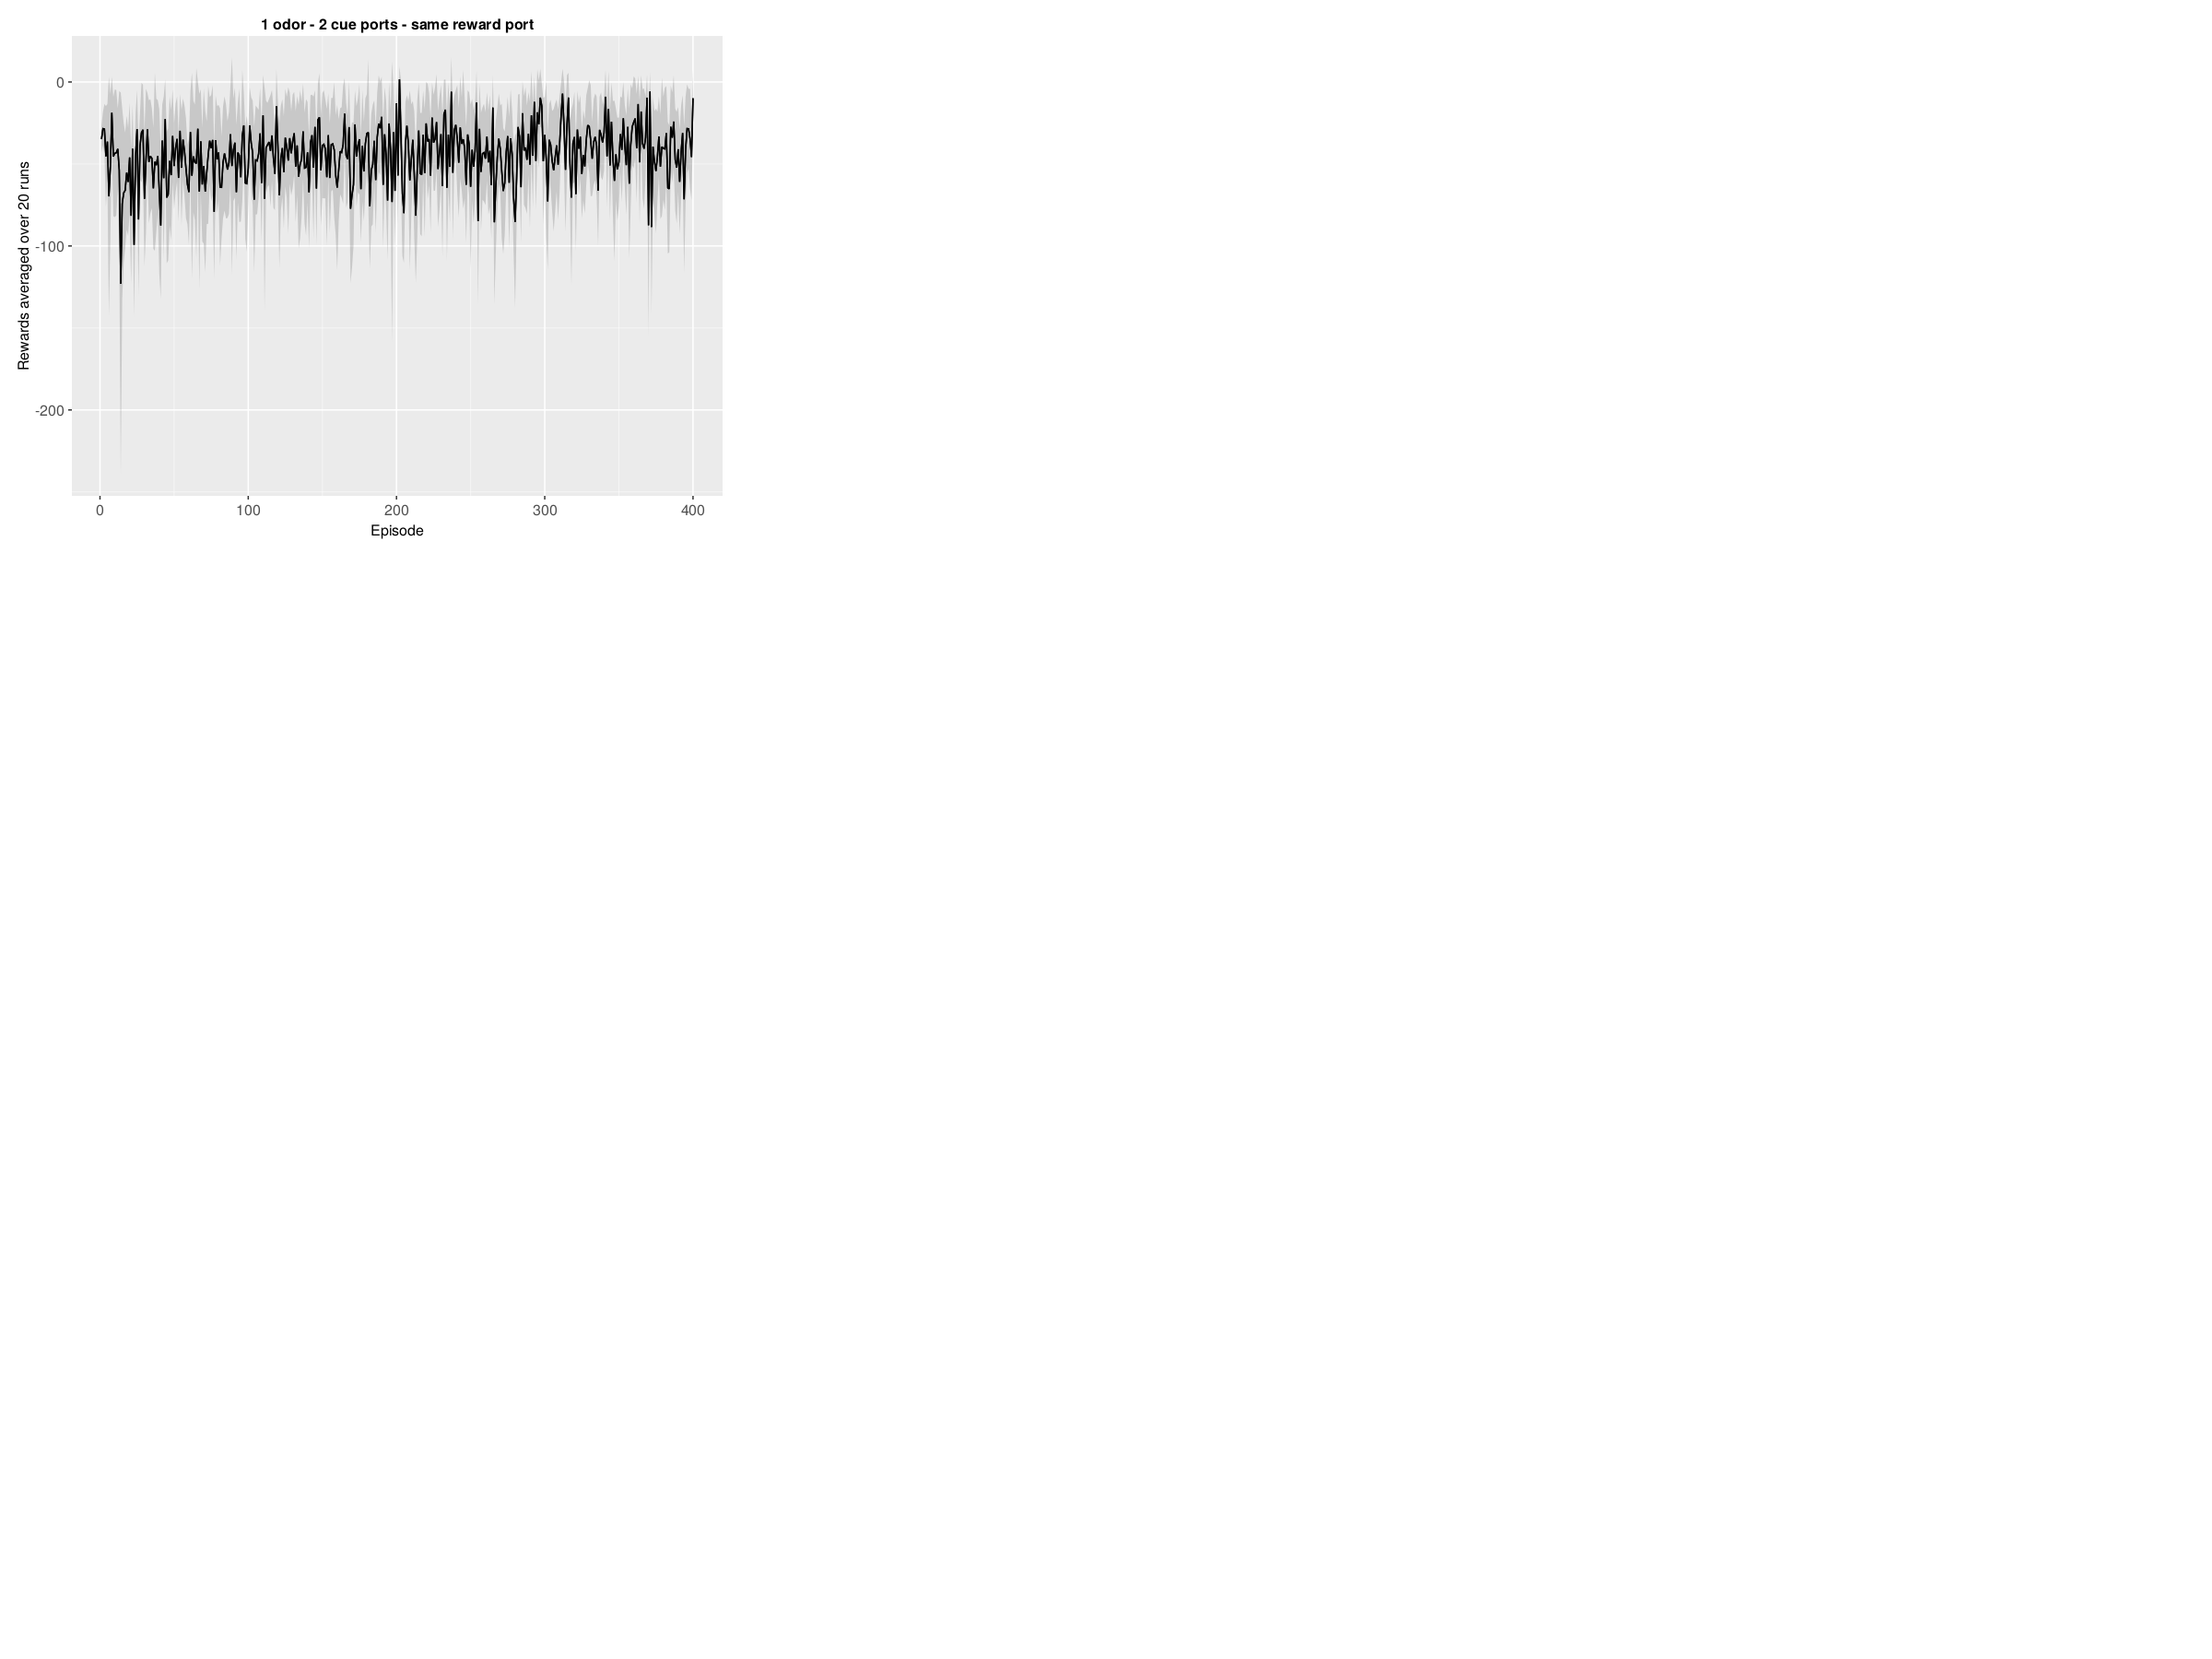

In [15]:
create_plot(plot_avg_cum_rewards; exp=exp, params=p, backgroundcolor=:white, open_plot=false, df=df, rewards=rewards)

Plot saved at:
/home/apierre/Dev/RL/plots/n_episodes=400_n_runs=20_plot=plot_avg_steps_title=1 odor - 2 cue ports - same reward port.png

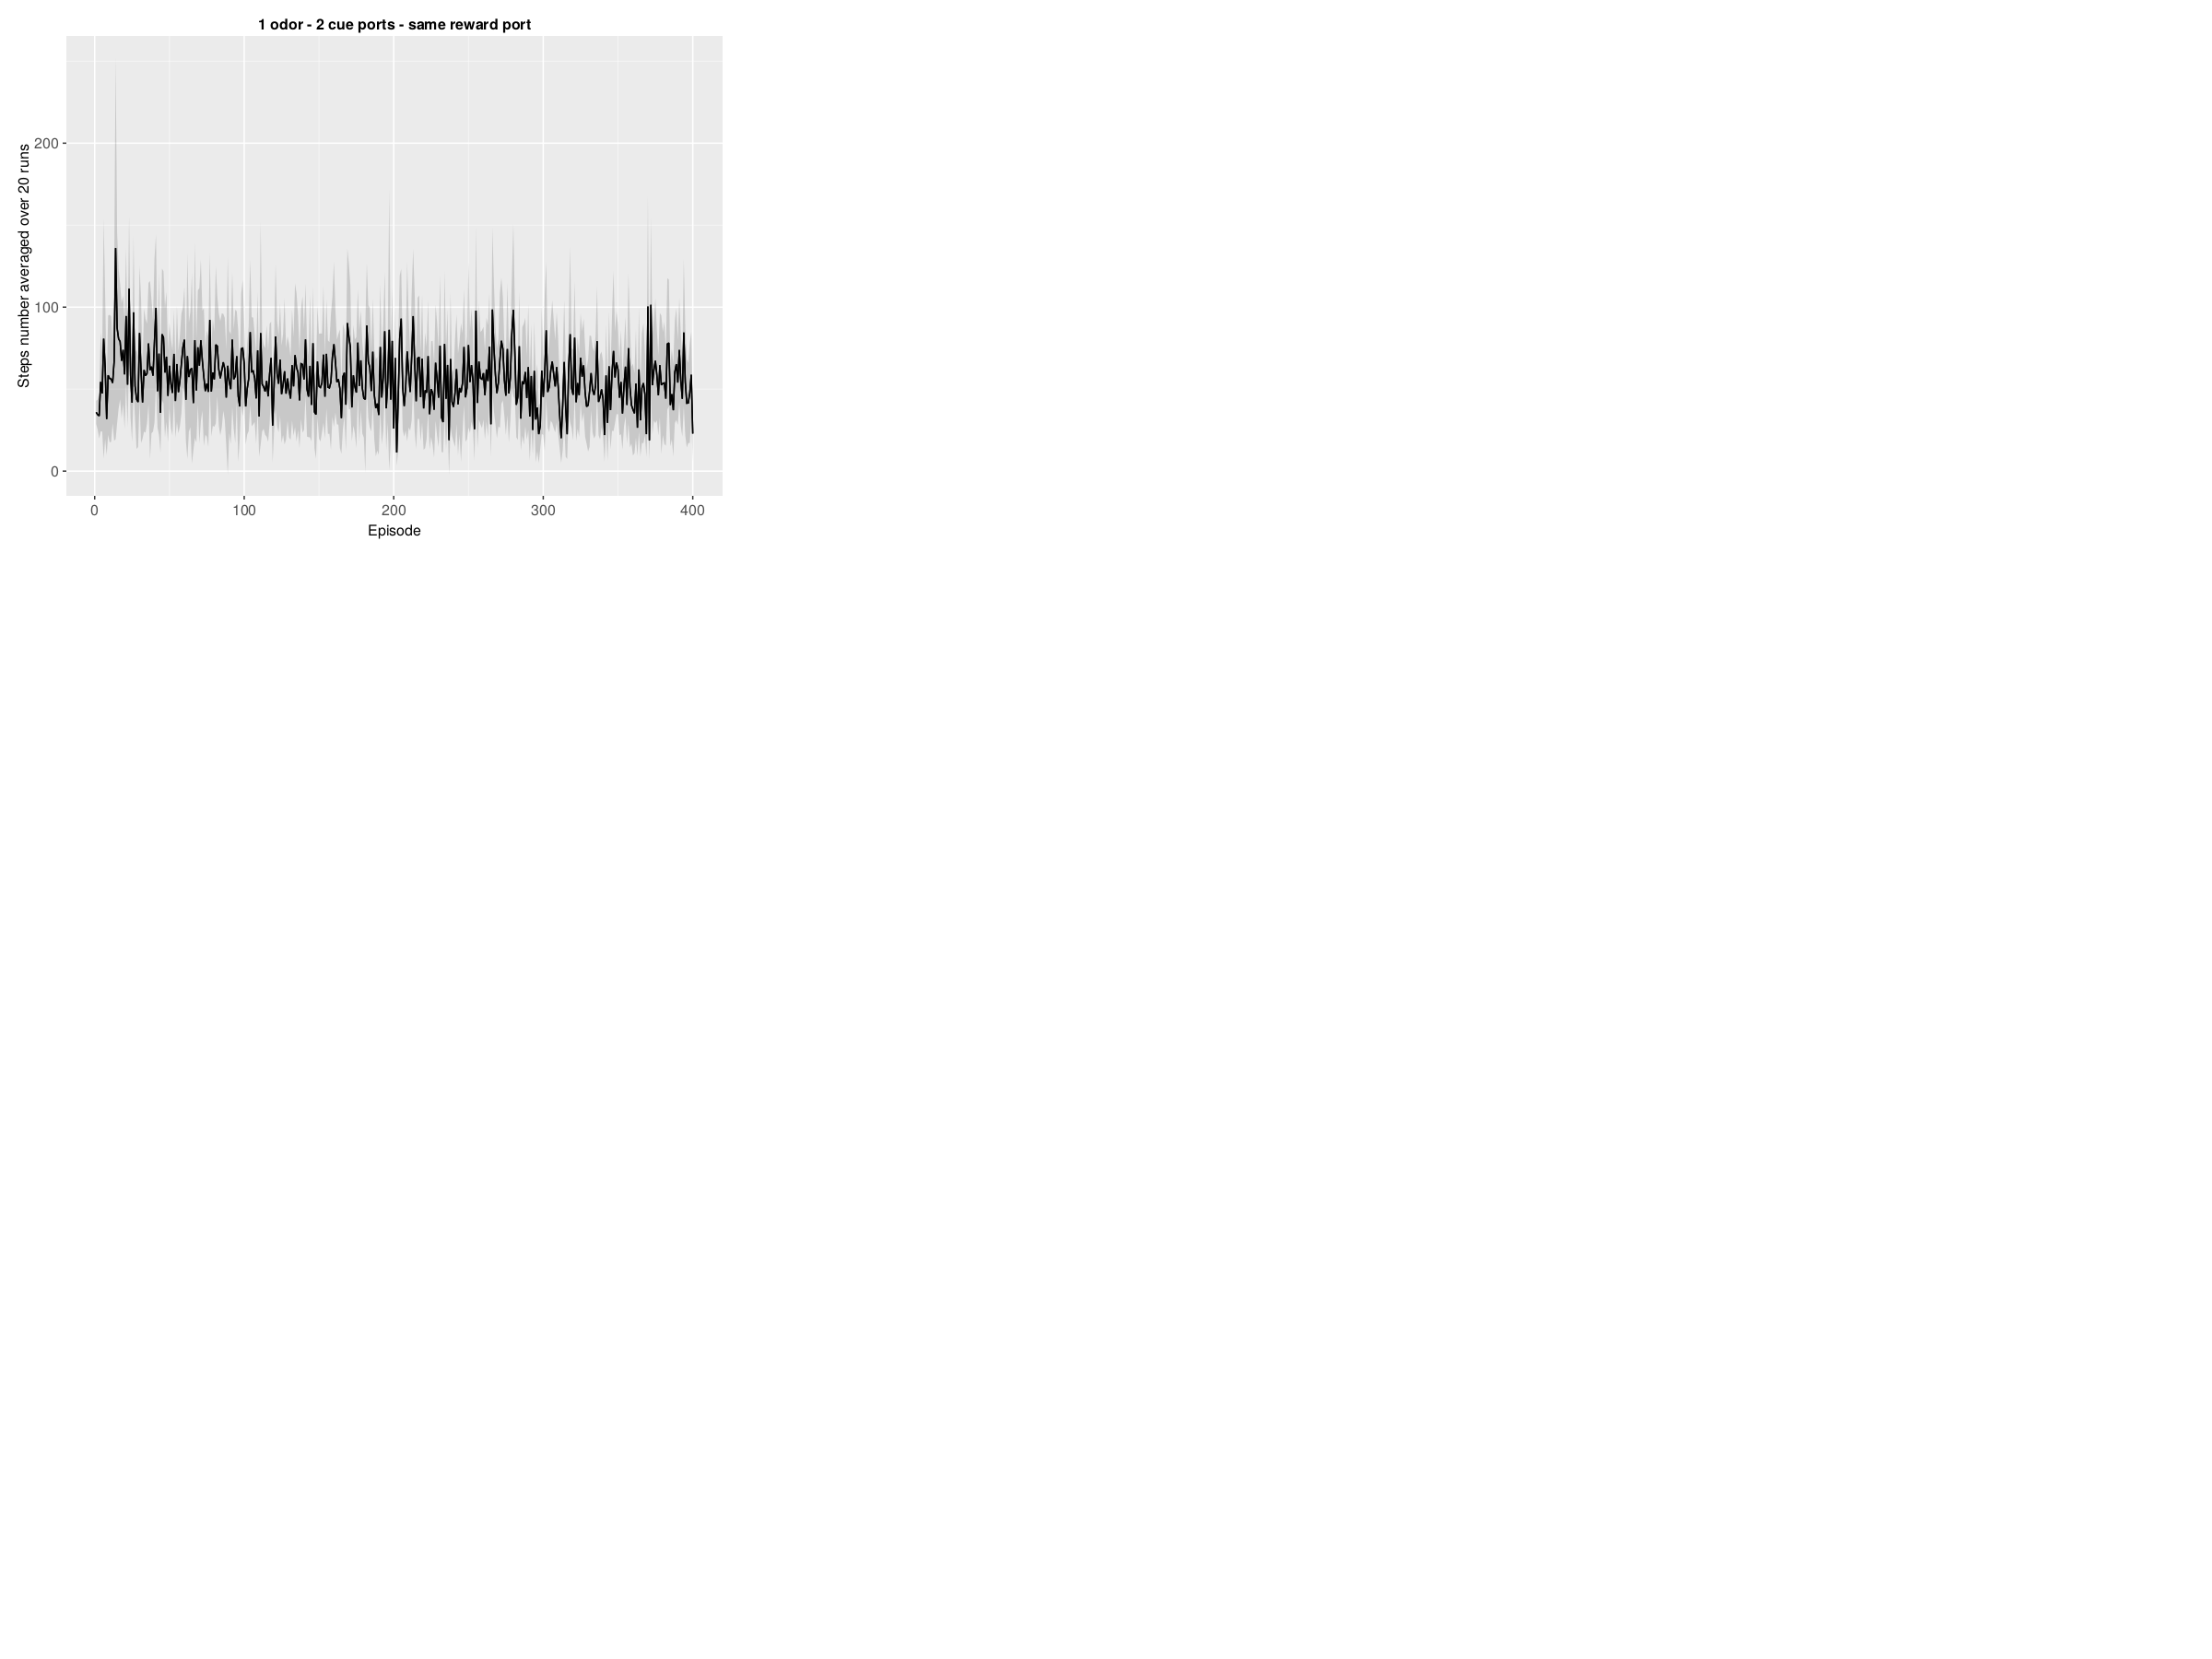

In [16]:
create_plot(plot_avg_steps; exp=exp, params=p, backgroundcolor=:white, open_plot=false, df=df, steps=steps)

In [17]:
policy = map(x -> x == 0.0 ? NaN : x, policy_table)

10×12 Matrix{Float64}:
  -8.77047   -2.64495   -9.04731   …   -8.86028    2.35164   NaN  NaN
  -8.27686   -3.0494   NaN            NaN        NaN         NaN  NaN
  -8.28009   -3.30147  NaN            NaN        NaN         NaN  NaN
 NaN        NaN          0.833653     NaN        NaN         NaN  NaN
  -8.77167   -3.44542  NaN            NaN        NaN         NaN  NaN
  -8.76448    2.78211  NaN         …  NaN        NaN         NaN  NaN
  -8.7365    -2.70538   -9.04117       -8.7056    -0.988057  NaN  NaN
 NaN        NaN        NaN            NaN          9.97489   NaN  NaN
 NaN        NaN        NaN            NaN        NaN         NaN  NaN
 NaN        NaN        NaN            NaN        NaN         NaN  NaN

Plot saved at:
/home/apierre/Dev/RL/plots/n_episodes=400_n_runs=20_plot=plot_policy_title=1 odor - 2 cue ports - same reward port.png

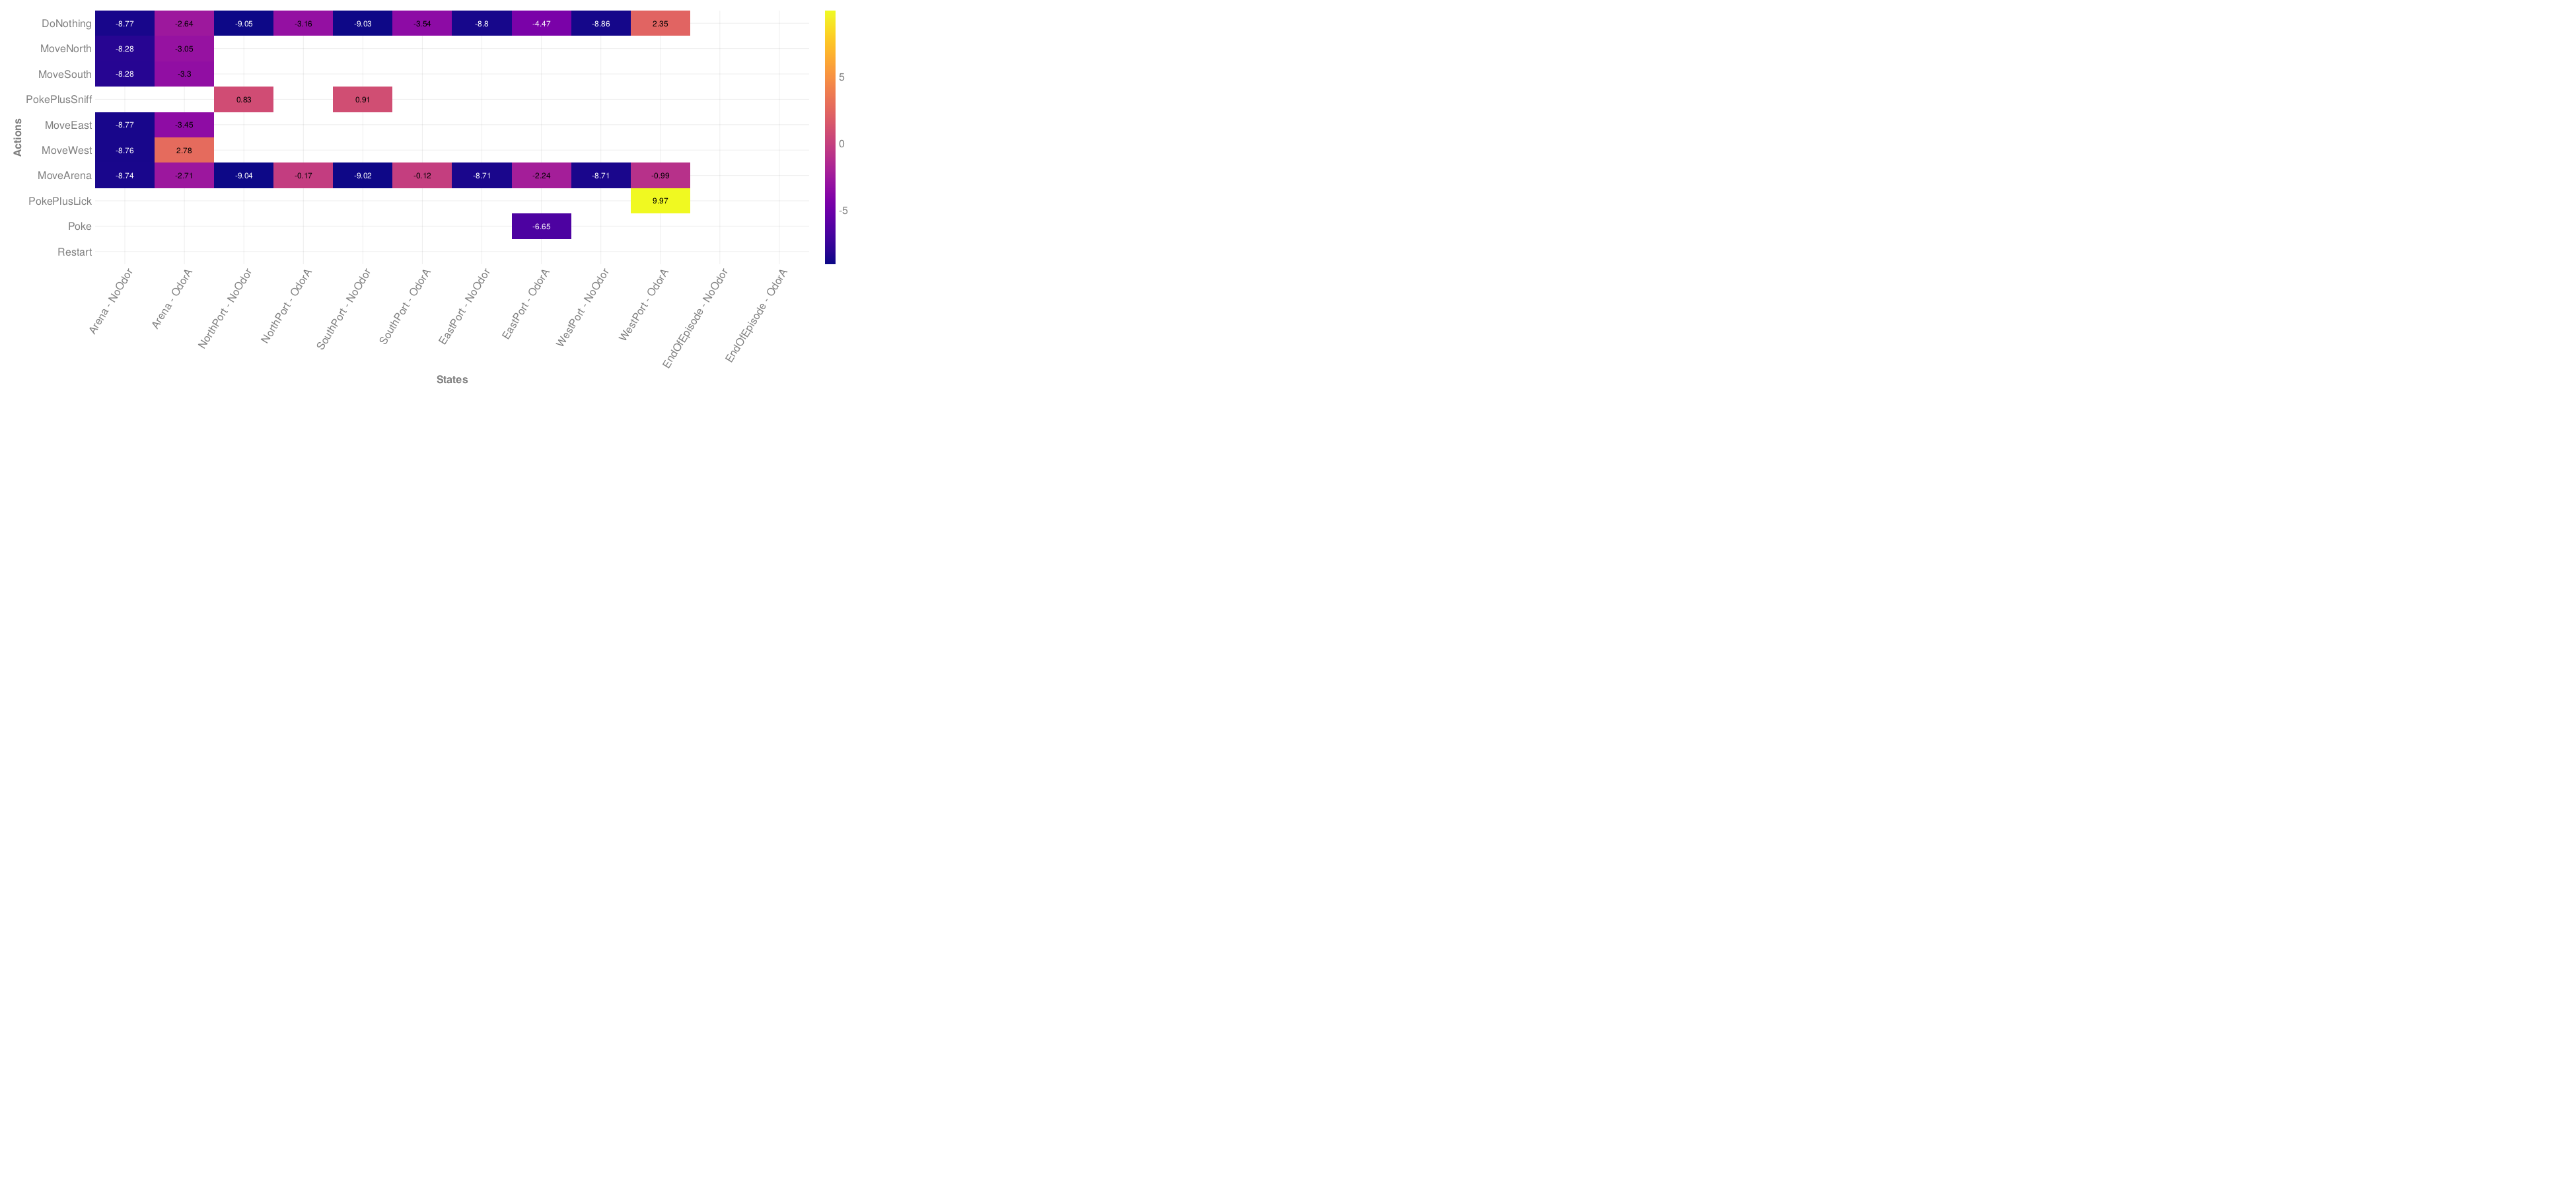

In [18]:
create_plot(plot_policy; exp=exp, params=p, backgroundcolor=:white, open_plot=false, theme=theme_light, policy_table=policy)

In [19]:
plot_visited_ports(df=ep, exp=exp, params=p, backgroundtransparent=false, saveplot=false)

Figure:
  above = []
  below = [
    LinearAxis:
      axis_label = "Steps"
  ]
  center = [
    Grid:
      axis = ...
      dimension = 0
    Grid:
      axis = LinearAxis:
        axis_label = "Ports"
        major_label_overrides = Dict(
          "4" => "West"
          "1" => "North"
          "2" => "South"
          "3" => "East"
        )
        ticker = FixedTicker:
          ticks = [
            1.0
            2.0
            3.0
            4.0
          ]
      dimension = 1
    Legend:
      items = [
        LegendItem:
          label = Value("Odor cue")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => [
                    2
                    36
                    61
                    82
                    105
                    ...
                  ]
                  "y" => [
                    2.0
                    2.0
                    2.0
                    1.0
                    2.0
                    ...
                  ]
                )
              glyph = Scatter:
                fill_alpha = Value(0.5)
                fill_color = Value("#ffd700")
                hatch_color = Value("#ffd700")
                line_color = Value("#ffd700")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
        LegendItem:
          label = Value("Reward")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => []
                  "y" => []
                )
              glyph = Scatter:
                fill_alpha = Value(0.4)
                fill_color = Value("#00ffff")
                hatch_color = Value("#00ffff")
                line_color = Value("#00ffff")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
      ]
  ]
  height = 600
  left = [
    ...
  ]
  renderers = [
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            2
            3
            4
            5
            12
            ...
          ]
          "y" => [
            2
            2
            2
            2
            1
            ...
          ]
        )
      glyph = Line:
        line_alpha = 0.3
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    ...
    ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            12
            13
            16
            19
            20
            ...
          ]
          "y" => [
            1
            1
            1
            1
            1
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#1f77b4")
        hatch_color = Value("#1f77b4")
        line_color = Value("#1f77b4")
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            2
            3
            4
            5
            36
            ...
          ]
          "y" => [
            2
            2
            2
            2
            2
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#ff7f0e")
        hatch_color = Value("#ff7f0e")
        line_color = Value("#ff7f0e")
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    ...
  ]
  right = []
  title = Title:
    text = "Visited ports"
  toolbar = Toolbar:
    tools = [
      PanTool: (blank)
      BoxZoomTool: (blank)
      WheelZoomTool: (blank)
      SaveTool: (blank)
      ResetTool: (blank)
      ...
    

In [20]:
ep_subset = ep[(ep.steps.>=0).&(ep.steps.<=1500), :]
plot_visited_ports(df=ep_subset, exp=exp, params=p, backgroundtransparent=false, saveplot=true)

Plot saved at:
/home/apierre/Dev/RL/plots/n_episodes=400_n_runs=20_plot=visited_ports_title=1 odor - 2 cue ports - same reward port.png

Figure:
  above = []
  below = [
    LinearAxis:
      axis_label = "Steps"
  ]
  center = [
    Grid:
      axis = ...
      dimension = 0
    Grid:
      axis = LinearAxis:
        axis_label = "Ports"
        major_label_overrides = Dict(
          "4" => "West"
          "1" => "North"
          "2" => "South"
          "3" => "East"
        )
        ticker = FixedTicker:
          ticks = [
            1.0
            2.0
            3.0
            4.0
          ]
      dimension = 1
    Legend:
      items = [
        LegendItem:
          label = Value("Odor cue")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => [
                    2
                    36
                    61
                    82
                    105
                    ...
                  ]
                  "y" => [
                    2.0
                    2.0
                    2.0
                    1.0
                    2.0
                    ...
                  ]
                )
              glyph = Scatter:
                fill_alpha = Value(0.5)
                fill_color = Value("#ffd700")
                hatch_color = Value("#ffd700")
                line_color = Value("#ffd700")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
        LegendItem:
          label = Value("Reward")
          renderers = [
            GlyphRenderer:
              data_source = ColumnDataSource:
                data = Dict(
                  "x" => []
                  "y" => []
                )
              glyph = Scatter:
                fill_alpha = Value(0.4)
                fill_color = Value("#00ffff")
                hatch_color = Value("#00ffff")
                line_color = Value("#00ffff")
                size = Value(12.0)
                x = Field("x")
                y = Field("y")
              view = CDSView:
                source = ...
          ]
      ]
  ]
  height = 600
  left = [
    ...
  ]
  renderers = [
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            2
            3
            4
            5
            12
            ...
          ]
          "y" => [
            2
            2
            2
            2
            1
            ...
          ]
        )
      glyph = Line:
        line_alpha = 0.3
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    ...
    ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            12
            13
            16
            19
            20
            ...
          ]
          "y" => [
            1
            1
            1
            1
            1
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#1f77b4")
        hatch_color = Value("#1f77b4")
        line_color = Value("#1f77b4")
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    GlyphRenderer:
      data_source = ColumnDataSource:
        data = Dict(
          "x" => [
            2
            3
            4
            5
            36
            ...
          ]
          "y" => [
            2
            2
            2
            2
            2
            ...
          ]
        )
      glyph = Scatter:
        fill_color = Value("#ff7f0e")
        hatch_color = Value("#ff7f0e")
        line_color = Value("#ff7f0e")
        x = Field("x")
        y = Field("y")
      view = CDSView:
        source = ...
    ...
  ]
  right = []
  title = Title:
    text = "Visited ports"
  toolbar = Toolbar:
    tools = [
      PanTool: (blank)
      BoxZoomTool: (blank)
      WheelZoomTool: (blank)
      SaveTool: (blank)
      ResetTool: (blank)
      ...
    